NLP PROJECT

In [1]:
#Set up the environment
%pip install -r ../requirements.txt

#Use only if you are using Google Colab
#from google.colab import files
#uploaded = files.upload()

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from transformers import pipeline

df = pd.read_csv('../data/proverbs.csv')
#print(df.head())

/Users/giorgosdaskalopoulos/Documents/MsC/3rd Semester/NLP Seminar/IronyDetection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Drop rows with missing values in the specified columns
df = df.dropna(subset=['Literal English Translation', 'Meaning'])

from nltk.corpus import stopwords
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return ' '.join(tokens)

# Apply preprocessing
df['Literal English Translation'] = df['Literal English Translation'].apply(preprocess)
df['Meaning'] = df['Meaning'].apply(preprocess)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/giorgosdaskalopoulos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/giorgosdaskalopoulos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/giorgosdaskalopoulos/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# Initialize sentiment analysis pipeline using a pre-trained transformer model
irony_analysis = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-irony")

df['predicted_irony'] = df['Literal English Translation'].apply(lambda x: irony_analysis(x)[0]['label']).map({'irony': 1, 'non_irony': 0})
df['predicted_irony_2'] = df['Proverb'].apply(lambda x: irony_analysis(x)[0]['label']).map({'irony': 1, 'non_irony': 0})

#df.value_counts('predicted_irony')
#df.value_counts('predicted_irony_2')

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix
df['actual_irony'] = df['Irony (Yes/No)'].astype(str).str.lower().map({'yes': 1, 'no': 0})

accuracy = accuracy_score(df['actual_irony'], df['predicted_irony'])
accuracy2 = accuracy_score(df['actual_irony'], df['predicted_irony_2'])

print(f'Accuracy from Literal English Translation: {accuracy}')
print(f'Accuracy from Original Proverb: {accuracy2}')

#confusion_matrix(df['actual_irony'], df['predicted_irony'], normalize='true')

Accuracy from Literal English Translation: 0.4166666666666667
Accuracy from Original Proverb: 0.4375


In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
df['actual_irony'] = df['Irony (Yes/No)'].astype(str).str.lower().map({'yes': 1, 'no': 0})

accuracy = accuracy_score(df['actual_irony'], df['predicted_irony'])
print(f'Accuracy: {accuracy}')

confusion_matrix(df['actual_irony'], df['predicted_irony'], normalize='true')

# Get the classification report as a dictionary
report = classification_report(df['actual_irony'], df['predicted_irony'], output_dict=True)

# Calculate confusion matrix
conf_matrix = confusion_matrix(df['actual_irony'], df['predicted_irony'])
tn, fp, fn, tp = conf_matrix.ravel()

Accuracy: 0.4166666666666667


In [7]:
# Extract metrics
precision = report['1']['precision']  # Precision for Ironic class
recall = report['1']['recall']  # Recall for Ironic class (Sensitivity)
specificity = tn / (tn + fp)  # Specificity (True Negative Rate)
accuracy = report['accuracy']  # Overall accuracy

# Print the metrics
# precision: Out of all the proverbs the model predicted as ironic, what proportion was actually ironic?
print(f"Precision: {precision:.4f}")
#recall/sensitivity: Out of all the proverbs that were actually ironic, what proportion did the model correctly identify as ironic?
print(f"Recall (Sensitivity): {recall:.4f}")
#specifity: Out of all the proverbs that were actually not ironic, what proportion did the model correctly identify as not ironic?
print(f"Specificity: {specificity:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Print the overall report for reference
print(classification_report(df['actual_irony'], df['predicted_irony']))

Precision: 0.4615
Recall (Sensitivity): 0.2222
Specificity: 0.6667
Accuracy: 0.4167
              precision    recall  f1-score   support

           0       0.40      0.67      0.50        42
           1       0.46      0.22      0.30        54

    accuracy                           0.42        96
   macro avg       0.43      0.44      0.40        96
weighted avg       0.43      0.42      0.39        96




Evaluating performance per language...

Performance Metrics for Greek:
Precision: 0.5714
Recall (Sensitivity): 0.2667
Specificity: 0.8000
Accuracy: 0.5333

Performance Metrics for German:
Precision: 0.3846
Recall (Sensitivity): 0.2381
Specificity: 0.4667
Accuracy: 0.3333

Performance Metrics for Italian:
Precision: 0.5000
Recall (Sensitivity): 0.1667
Specificity: 0.7500
Accuracy: 0.4000

Language with the worst performance: German
Metrics for German:
Language         German
Precision      0.384615
Recall         0.238095
Specificity    0.466667
Accuracy       0.333333
Name: 1, dtype: object


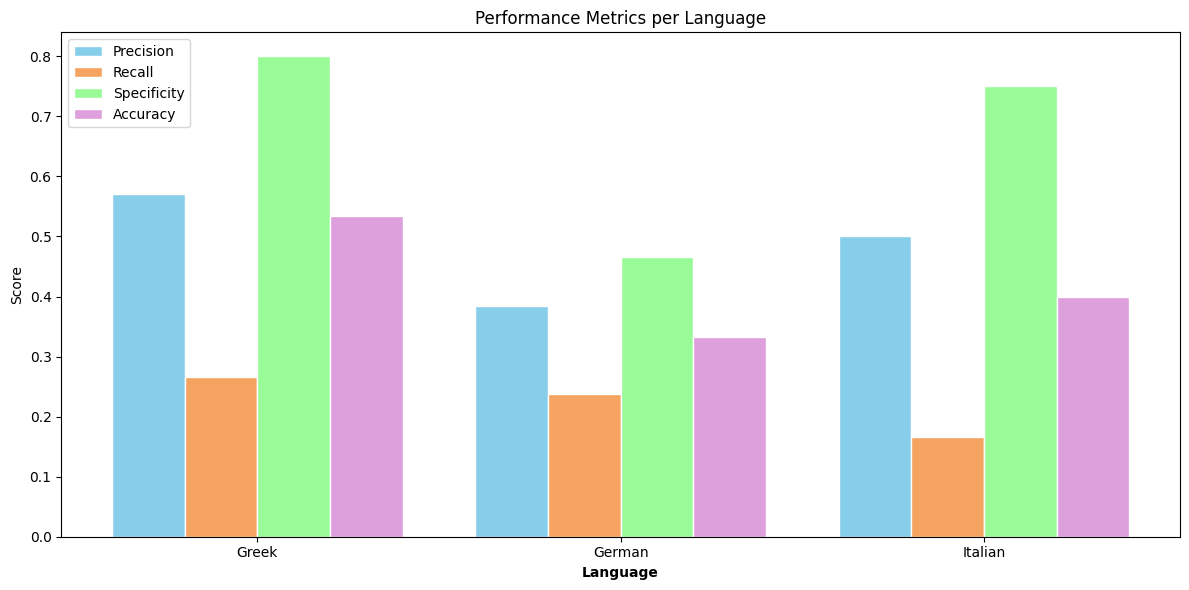

In [8]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Evaluate performance per language
print("\nEvaluating performance per language...\n")
languages = df['Language'].unique()
performance_metrics = []

for language in languages:
    df_lang = df[df['Language'] == language]
    true_labels = df_lang['actual_irony']
    pred_labels = df_lang['predicted_irony']

    # Check if both classes are present in the subset
    if len(true_labels.unique()) < 2:
        print(f"Language '{language}' does not have both classes. Skipping metrics calculation for this language.")
        continue

    # Calculate metrics
    report_lang = classification_report(true_labels, pred_labels, output_dict=True)
    conf_matrix_lang = confusion_matrix(true_labels, pred_labels)
    tn_l, fp_l, fn_l, tp_l = conf_matrix_lang.ravel()

    precision_l = report_lang['1']['precision']
    recall_l = report_lang['1']['recall']
    specificity_l = tn_l / (tn_l + fp_l)
    accuracy_l = report_lang['accuracy']

    # Append metrics to the list
    performance_metrics.append({
        'Language': language,
        'Precision': precision_l,
        'Recall': recall_l,
        'Specificity': specificity_l,
        'Accuracy': accuracy_l
    })

    # Print metrics for the language
    print(f"Performance Metrics for {language}:")
    print(f"Precision: {precision_l:.4f}")
    print(f"Recall (Sensitivity): {recall_l:.4f}")
    print(f"Specificity: {specificity_l:.4f}")
    print(f"Accuracy: {accuracy_l:.4f}\n")

# Create a DataFrame for performance metrics
performance_df = pd.DataFrame(performance_metrics)

# Identify the language with the worst performance based on accuracy
worst_language = performance_df.loc[performance_df['Accuracy'].idxmin()]
print(f"Language with the worst performance: {worst_language['Language']}")
print(f"Metrics for {worst_language['Language']}:")
print(worst_language)

# Plotting metrics per language with different colors
metrics = ['Precision', 'Recall', 'Specificity', 'Accuracy']

# Set up bar width and positions
bar_width = 0.2
r1 = np.arange(len(performance_df['Language']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width*2 for x in r1]
r4 = [x + bar_width*3 for x in r1]

plt.figure(figsize=(12,6))

# Plot each metric
plt.bar(r1, performance_df['Precision'], color='skyblue', width=bar_width, edgecolor='white', label='Precision')
plt.bar(r2, performance_df['Recall'], color='sandybrown', width=bar_width, edgecolor='white', label='Recall')
plt.bar(r3, performance_df['Specificity'], color='palegreen', width=bar_width, edgecolor='white', label='Specificity')
plt.bar(r4, performance_df['Accuracy'], color='plum', width=bar_width, edgecolor='white', label='Accuracy')

# Add xticks on the middle of the group bars
plt.xlabel('Language', fontweight='bold')
plt.xticks([r + bar_width*1.5 for r in range(len(performance_df['Language']))], performance_df['Language'])

# Add y-axis label and title
plt.ylabel('Score')
plt.title('Performance Metrics per Language')

# Add legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()
